We want to know which protease is most suitable for analysing NLS which are very very lysine and arginine rich and therefore may not be covered by tryptic peptides.

We can use the data from:

Confetti: A Multiprotease Map of the HeLa Proteome for Comprehensive Proteomics

to assess which protease or combination gives the best coverage of NLS in the HeLa Proteome.

The Confetti_sorted_peptides.csv file contains 429364 unique peptides with no indication which protein they come from! We need to match each peptide to the protein source!!

First, let's get the sequences for each protein in the human (reviewed) proteome

In [1]:
from bioservices import UniProt
from proteomics import sequence

import numpy as np
import re
import urllib3
import requests
import collections
import json
from time import gmtime, strftime
import importlib
import pandas as pd
import CGAT.IOTools as IOTools

%load_ext rpy2.ipython

In [2]:
importlib.reload(sequence)

<module 'proteomics.sequence' from '/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/proteomics/sequence.py'>

In [3]:
u = UniProt()

u_results = u.search("organism:9606+and+reviewed:yes", columns="id,entry name", limit=-1)

In [4]:
uniprot_ids_df = pd.DataFrame.from_records(
        [x.split() for x in u_results.strip().split("\n")[1:]],
        columns=["uniprot_id", "name"])

print(uniprot_ids_df.head())
print(uniprot_ids_df.shape)

  uniprot_id         name
0     P04637    P53_HUMAN
1     Q14524  SCN5A_HUMAN
2     P35555   FBN1_HUMAN
3     P00533   EGFR_HUMAN
4     P00451    FA8_HUMAN
(20183, 2)


In [5]:
protein_seq = {}

text = sequence.getSequences(uniprot_ids_df['uniprot_id'])
methods = collections.Counter()
n = 0
for protein in text:
    protein_seq[protein[0]] = protein[1]
    methods[protein[2]] += 1
    if len(protein[1])<10:
        print(protein)
    n+=1
    if n%1000==0:
        print(n)
        print(methods)
    
print(n)
print(methods)


('P0DOY5', 'GTTGT', 'ebi_api')
1000
Counter({'ebi_api': 1000})
2000
Counter({'ebi_api': 2000})
3000
Counter({'ebi_api': 3000})
4000
Counter({'ebi_api': 4000})
5000
Counter({'ebi_api': 5000})
6000
Counter({'ebi_api': 6000})
('P01858', 'TKPR', 'ebi_api')
7000
Counter({'ebi_api': 7000})
8000
Counter({'ebi_api': 8000})
9000
Counter({'ebi_api': 9000})
10000
Counter({'ebi_api': 10000})
11000
Counter({'ebi_api': 11000})
12000
Counter({'ebi_api': 12000})
13000
Counter({'ebi_api': 13000})
14000
Counter({'ebi_api': 14000})
('P02729', 'CEHSHDGA', 'ebi_api')
15000
Counter({'ebi_api': 15000})
16000
Counter({'ebi_api': 16000})
17000
Counter({'ebi_api': 17000})
18000
Counter({'ebi_api': 18000})
19000
Counter({'ebi_api': 19000})
20000
Counter({'ebi_api': 20000})
20183
Counter({'ebi_api': 20183})


In [6]:
for protein in protein_seq:
    seq = protein_seq[protein]
    if seq is None or len(seq)==0:
        print(protein, seq)

In [7]:
print(len(protein_seq))

20183


In [8]:
nls_blocks = collections.defaultdict(list)
nls_url = ('https://www.ebi.ac.uk/proteins/api/features?size=10000'
           '&taxid=9606&categories=DOMAINS_AND_SITES&types=MOTIF&reviewed=true')
print(nls_url)
r = requests.get(nls_url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for motif in p_ix['features']:
        if 'Nuclear localization signal' in motif['description']:
            nls_blocks[p_ix['accession']].append((int(motif['begin']), int(motif['end'])))


https://www.ebi.ac.uk/proteins/api/features?size=10000&taxid=9606&categories=DOMAINS_AND_SITES&types=MOTIF&reviewed=true


In [9]:
tm_blocks = collections.defaultdict(list)
tm_url = ('https://www.ebi.ac.uk/proteins/api/features?offset=0&size=10000'
          '&taxid=9606&types=TRANSMEM&reviewed=true')
print(tm_url)
r = requests.get(tm_url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for feature in p_ix['features']:
        if feature['type'] == 'TRANSMEM':
            tm_blocks[p_ix['accession']].append((int(feature['begin']), int(feature['end'])))
print(p_ix)

https://www.ebi.ac.uk/proteins/api/features?offset=0&size=10000&taxid=9606&types=TRANSMEM&reviewed=true
{'features': [{'category': 'TOPOLOGY', 'description': 'Helical', 'end': '33', 'type': 'TRANSMEM', 'begin': '13', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'description': 'Helical', 'end': '68', 'type': 'TRANSMEM', 'begin': '48', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'description': 'Helical', 'end': '179', 'type': 'TRANSMEM', 'begin': '159', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'description': 'Helical', 'end': '221', 'type': 'TRANSMEM', 'begin': '201', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'description': 'Helical', 'end': '244', 'type': 'TRANSMEM', 'begin': '224', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'description': 'Helical', 'end': '277', 'type': 'TRANSMEM', 'begin': '260', 'evidences': [{'code': 'ECO:0000255'}]}, {'category': 'TOPOLOGY', 'descript

In [10]:
print(len(nls_blocks))
print(len(tm_blocks))
print(len(set(nls_blocks).union(set(tm_blocks))))

442
5196
5628


In [11]:
nls_proteins = set(nls_blocks).intersection(set(protein_seq))
print(len(nls_proteins))
tm_proteins = set(tm_blocks).intersection(set(protein_seq))
print(len(tm_proteins))

441
5196


In [13]:
nls_ks = collections.defaultdict(set)
for protein in nls_proteins:
    blocks = nls_blocks[protein]
    for block in blocks:
        nls = protein_seq[protein][block[0]-1:block[1]]
        nls_ks[protein].update(
            [block[0] + ix for ix, base in enumerate(nls) if base == 'K'])
    
print(blocks)
print(protein_seq[protein][block[0]-1:block[1]])
print(protein)
print(nls_ks[protein])
print(len(nls_ks))
print(sum([len(nls_ks[x]) for x in nls_ks]))
    

[(517, 528)]
DKFLIIPLHSLM
Q9H2U1
{518}
441
1657


In [14]:
current_pep = ""
n= 0

with IOTools.openFile("../raw/Confetti_sorted_peptides.csv", "r") as inf:
    with IOTools.openFile("../raw/Confetti_sorted_peptides_matched.csv", "w") as outf:
        header = next(inf)
        header = header.strip().replace('"', '').split(",")
        header.append("matches")
        outf.write("%s\n" % "\t".join(header))

        for line in inf:
            n+=1
            #if n > 1000000:
            #    break
            if n % 100000 == 0:
                print('lines done: %i %s' % (
                        n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))

            line = line.strip().replace('"', '').split(",")
            
            pep_seq = line[0]

            if pep_seq != current_pep:
                
                matches = set()
            
                for protein in nls_proteins:
                    seq = protein_seq[protein]
                    if pep_seq in seq:
                        matches.add(protein)
                
                for protein in tm_proteins:
                    seq = protein_seq[protein]
                    if pep_seq in seq:
                        matches.add(protein)
            if len(matches) == 0:
                line.append("None")
            else:
                line.append(";".join(matches))
            outf.write("%s\n" % "\t".join(line))
                    
                

lines done: 100000 2017-03-29 11:18:14
lines done: 200000 2017-03-29 11:24:24
lines done: 300000 2017-03-29 11:30:22
lines done: 400000 2017-03-29 11:36:18
lines done: 500000 2017-03-29 11:41:49
lines done: 600000 2017-03-29 11:47:17
lines done: 700000 2017-03-29 11:52:42
lines done: 800000 2017-03-29 11:58:00
lines done: 900000 2017-03-29 12:03:55
lines done: 1000000 2017-03-29 12:10:08
lines done: 1100000 2017-03-29 12:15:30
lines done: 1200000 2017-03-29 12:20:44
lines done: 1300000 2017-03-29 12:26:07
lines done: 1400000 2017-03-29 12:31:33
lines done: 1500000 2017-03-29 12:36:59
lines done: 1600000 2017-03-29 12:42:44
lines done: 1700000 2017-03-29 12:48:21
lines done: 1800000 2017-03-29 12:54:12
lines done: 1900000 2017-03-29 12:59:41
lines done: 2000000 2017-03-29 13:05:03
lines done: 2100000 2017-03-29 13:10:27
lines done: 2200000 2017-03-29 13:15:52
lines done: 2300000 2017-03-29 13:21:34
lines done: 2400000 2017-03-29 13:26:45
lines done: 2500000 2017-03-29 13:31:41
lines don

In [15]:
print(tm_blocks['Q6ZT12'])

[(761, 781), (919, 939), (1806, 1826)]


In [35]:
nls_ks_covered = collections.defaultdict(lambda: collections.defaultdict(set))

tm_covered = collections.defaultdict(lambda: collections.defaultdict(set))
aa_covered = collections.defaultdict(lambda: collections.defaultdict(set))

tms_peptides = collections.defaultdict(lambda: collections.defaultdict(int))

n= 0

outf = IOTools.openFile("results/Confetti_intersect_nls.csv", "w")

with IOTools.openFile("../raw/Confetti_sorted_peptides_matched.csv", "r") as inf:
    header = next(inf)
    header = header.strip().split("\t")
    header.extend(["matched", "protein_matches", "nls_Ks"])
    outf.write("%s\n" % "\t".join(header))
    print(header)
    for line in inf:
        n+=1
        #if n > 500:
        #    break
        if n % 100000 == 0:
            print('lines done: %i %s' % (
                   n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))

        line = line.strip().split("\t")
        pep_seq = line[0]
        combination = ";".join(line[4:8])

        matches = line[-1].split(";")

        if matches[0] == 'Q04721':
            print(line)
        
        if len(matches) == 0:
            continue
                   
        nls_matches = set(matches).intersection(nls_proteins)
        tm_matches = set(matches).intersection(tm_proteins)

        if len(nls_matches) > 0:
            nls_matched = 1
            protein_matches = ";".join(matches)
            #print(seq[nls_blocks[protein][0]:nls_blocks[protein][1]])
            for match in nls_matches:
                seq = protein_seq[match]
                for m in re.finditer(pep_seq, seq):

                    ks_covered = set(
                        [m.start() + ix + 1 for ix, base in enumerate(pep_seq) if base == "K"])

                    covered_nls_ks = ks_covered.intersection(nls_ks[match])

                    nls_ks_covered[nls_matched][combination].update(covered_nls_ks)
            
            line_full = line
            line_full.extend([str(match), ";".join(matches), str(len(covered_nls_ks))])
            outf.write("%s\n" % "\t".join(line_full))
            
        else:
            nls_matched = 0
            protein_matches = ""
            covered_nls_ks = set()
        
        if len(tm_matches) == 0:
            continue
        
        
        
        protein_matches = ";".join(matches)
        for match in tm_matches:
            tms_peptides[match][combination] += 1
            tmp_tm_covered = set()
            tmp_aa_covered = set()
            seq = protein_seq[match]
            for m in re.finditer(pep_seq, seq):
                tmp_aa_covered.update(range(m.start(), m.end()+1))
                for block in tm_blocks[match]:
                    block_start, block_end = block
                    if not (m.start() > block_end or m.end() < block_start):
                        tmp_tm_covered.update(range(max(block_start, m.start()), min(block_end+1, m.end()) +1))   
            if len(tmp_aa_covered) == 0:
                print(line)
                raise ValueError()
            aa_covered[match][combination].update(tmp_aa_covered)
            tm_covered[match][combination].update(tmp_tm_covered)

outf.close()

print(line_full, pep_seq, len(pep_seq))
print('lines done: %i %s' % (n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))

['Peptide', 'Max iProphet Probability', 'PSM Count', 'Dataset', 'Digest', 'Fractionation', 'Instrument', 'Fragmentation', 'matches', 'matched', 'protein_matches', 'nls_Ks']
['AADIRRTPSLALTPPQAEQE', '0.997628', '7', '486', 'GluC', 'SAX', 'Thermo QExactive', 'HCD', 'Q04721']
['AEDEALLSEEDDPIDR', '0.999999', '2', '484', 'Trypsin', 'SAX', 'Thermo QExactive', 'HCD', 'Q04721']
lines done: 100000 2017-03-29 15:36:48
['ALGTLLHTNLR', '0.999591', '3', '487', 'ArgC-Trypsin', 'SAX', 'Thermo QExactive', 'HCD', 'Q04721']
lines done: 200000 2017-03-29 15:36:49
['AVAGPLPTMY', '0.965545', '1', '106', 'LysC-Chymotrypsin', 'Unfractionated', 'Thermo Orbitrap Elite', 'CID', 'Q04721']
['CLPGFAGER', '0.995407', '2', '484', 'Trypsin', 'SAX', 'Thermo QExactive', 'HCD', 'Q04721']
['CQTDMNECLSEPCK', '0.465031', '17', '484', 'Trypsin', 'SAX', 'Thermo QExactive', 'HCD', 'Q04721']
['DAAKRLL', '0.990821', '2', '483', 'AspN', 'SAX', 'Thermo Orbitrap Elite', 'CID', 'Q04721;P46531;Q9UM47']
['DAAKRLL', '0.990821', '2', 

In [60]:
print(tm_covered[list(tm_covered.keys())[3]])

defaultdict(<class 'set'>, {'GluC;SAX;Thermo QExactive;HCD': set(), 'Trypsin;SAX;Thermo Orbitrap Elite;CID': set(), 'AspN;SAX;Thermo QExactive;HCD': set(), 'GluC;SAX;Thermo Orbitrap Elite;CID': set(), 'Trypsin;SAX;Thermo QExactive;HCD': set()})


In [46]:
rows = []
header = ["protein", "digest", "fractionation", "instrument", "fragmentation",
          "aa_covered", "tms_covered", "total_aa", "total_tms", "tms", "peptides"]

for protein in tm_covered:
    protein_tms_values = tm_covered[protein]
    protein_aa_values = aa_covered[protein]
    tms = len(tm_blocks[protein])
    
    total_tm_aa = sum([(x[1]-x[0])+1 for x in tm_blocks[protein]])
    
    for combination in protein_tms_values:
        peptides = tms_peptides[protein][combination]
        digest, fractionation, instrument, fragmentation = combination.split(";")
        tmp_tm_covered = protein_tms_values[combination]
        tmp_aa_covered = protein_aa_values[combination]
        rows.append([protein, digest, fractionation, instrument, fragmentation,
                     len(tmp_aa_covered), len(tmp_tm_covered), len(protein_seq[protein]),
                     total_tm_aa, tms, peptides])


In [66]:
tm_proteins_df = pd.DataFrame.from_records(rows, columns=header)

print(tm_proteins_df.head())
print(tm_proteins_df.tail())
print(tm_proteins_df.shape)

tm_proteins_covered_df = tm_proteins_df[tm_proteins_df['tms_covered']>=10]

print(tm_proteins_covered_df.head())
print(tm_proteins_covered_df.shape)

print(tm_proteins_covered_df.sort_values("tms_covered").head())
print(tm_proteins_covered_df.sort_values("tms_covered", ascending=False).head())

print(tm_proteins_covered_df[tm_proteins_covered_df['protein']=='Q6ZT12'])

  protein               digest   fractionation             instrument  \
0  Q9P2V4         LysC-Trypsin  Unfractionated  Thermo Orbitrap Elite   
1  O95221        AspN-Elastase  Unfractionated  Thermo Orbitrap Elite   
2  Q8TBA6                 GluC  Unfractionated  Thermo Orbitrap Elite   
3  Q8TBA6              Trypsin             SAX       Thermo QExactive   
4  Q8TBA6  Cymotrypsin-Trypsin             SAX  Thermo Orbitrap Elite   

  fragmentation  aa_covered  tms_covered  total_aa  total_tms  tms  peptides  
0           CID           9            0       623         21    1         1  
1           CID          11            0       314        147    7         1  
2       CID-ETD          11            0       731         21    1         2  
3           HCD         234            0       731         21    1        36  
4           CID          98            0       731         21    1        16  
      protein        digest   fractionation             instrument  \
50814  Q6AZY7    

In [67]:
tm_proteins_covered_df['fraction_tms'] = tm_proteins_covered_df['tms_covered']/tm_proteins_covered_df['total_tms']
tm_proteins_covered_df['fraction_aa'] = tm_proteins_covered_df['aa_covered']/tm_proteins_covered_df['total_aa']

tm_proteins_covered_df['digest'] = tm_proteins_covered_df['digest'].replace(
    "Cymotrypsin-Trypsin", "Chymotrypsin-Trypsin")                            

print(tm_proteins_covered_df.head())

tm_proteins_agg = pd.DataFrame(tm_proteins_covered_df.groupby(
    ["digest", "fractionation", "instrument", "fragmentation"])[
        ['fraction_aa', 'fraction_tms']].agg(np.median).reset_index())

tm_proteins_agg2 = pd.DataFrame(tm_proteins_covered_df.groupby(
    ["digest", "fractionation", "instrument", "fragmentation"])["protein"].agg(len).reset_index())



print(tm_proteins_agg.head())
print(tm_proteins_agg.shape)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


    protein                digest   fractionation             instrument  \
26   Q969S0     LysC-Chymotrypsin  Unfractionated  Thermo Orbitrap Elite   
28   O75783         AspN-Elastase  Unfractionated       Thermo QExactive   
169  O75746  Chymotrypsin-Trypsin  Unfractionated  Thermo Orbitrap Elite   
173  O75746                  LysC             SAX  Thermo Orbitrap Elite   
174  O75746      Elastase-Trypsin  Unfractionated  Thermo Orbitrap Elite   

    fragmentation  aa_covered  tms_covered  total_aa  total_tms  tms  \
26            CID          10           10       331        227   11   
28            HCD          23           13       438        146    7   
169           CID          27           13       678        110    6   
173           CID          78           38       678        110    6   
174       CID-ETD          38           21       678        110    6   

     peptides  fraction_tms  fraction_aa  
26          1      0.044053     0.030211  
28          3      0.089

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [68]:
print(len(tm_blocks))

5196


In [69]:
%%R -i tm_proteins_agg
print(table(tm_proteins_agg$digest, tm_proteins_agg$fractionation))


                               
                                SAX Unfractionated
  ArgC                            0              4
  ArgC-AspN                       0              3
  ArgC-Chymotrypsin               0              3
  ArgC-Elastase                   0              3
  ArgC-GluC                       0              2
  ArgC-LysC                       0              3
  ArgC-Trypsin                    1              3
  AspN                            2              4
  AspN-Chymotrypsin               0              3
  AspN-Chymotrypsin-Elastase      0              2
  AspN-Chymotrypsin-Trypsin       0              2
  AspN-Elastase                   0              3
  AspN-Elastase-Trypsin           0              2
  AspN-GluC                       0              3
  AspN-GluC-Chymotrypsin          0              2
  AspN-GluC-Elastase              0              2
  AspN-GluC-LysC                  0              2
  AspN-GluC-Trypsin               0              2

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.94 x 13.9 in image

  warnings.warn(x, RRuntimeWarning)


             digest  fractionation            instrument fragmentation protein
0              ArgC Unfractionated Thermo Orbitrap Elite           CID       6
3              ArgC Unfractionated      Thermo QExactive           HCD      10
4         ArgC-AspN Unfractionated Thermo Orbitrap Elite           CID       8
6         ArgC-AspN Unfractionated      Thermo QExactive           HCD       9
7 ArgC-Chymotrypsin Unfractionated Thermo Orbitrap Elite           CID       4
9 ArgC-Chymotrypsin Unfractionated      Thermo QExactive           HCD       9


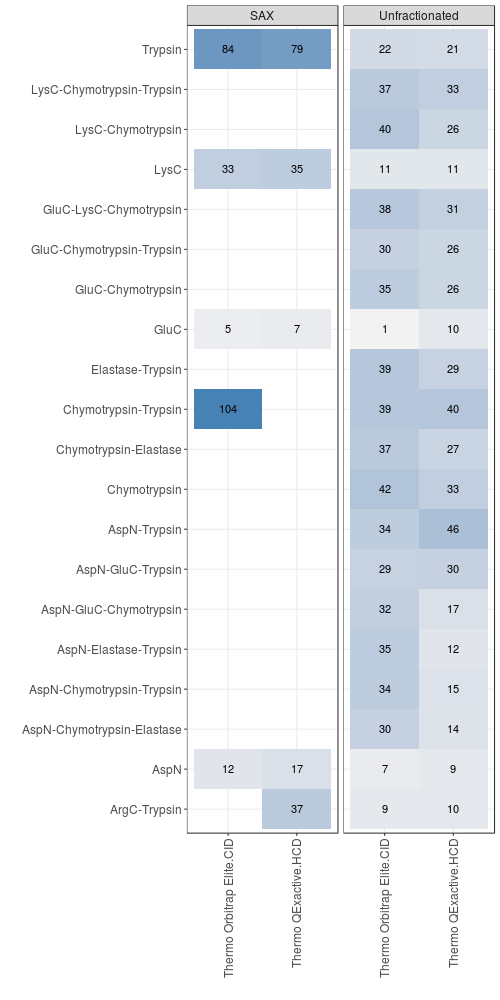

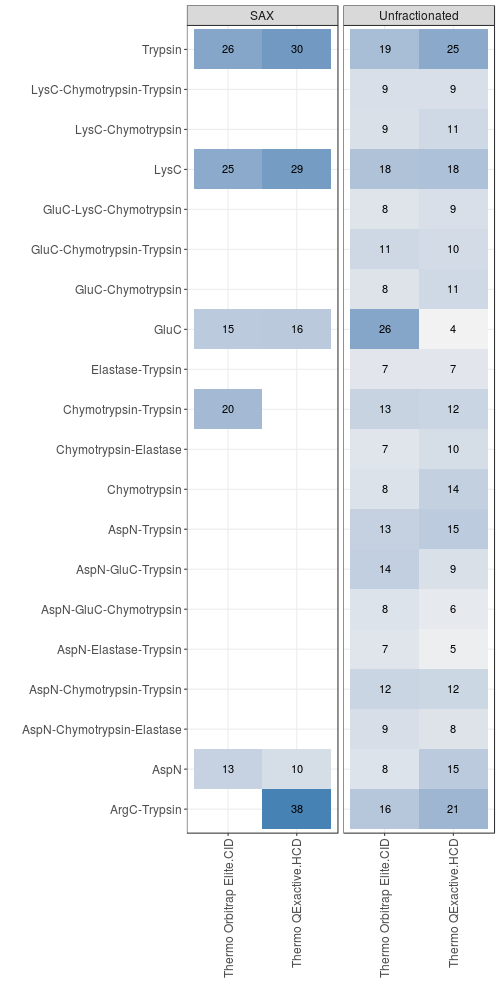

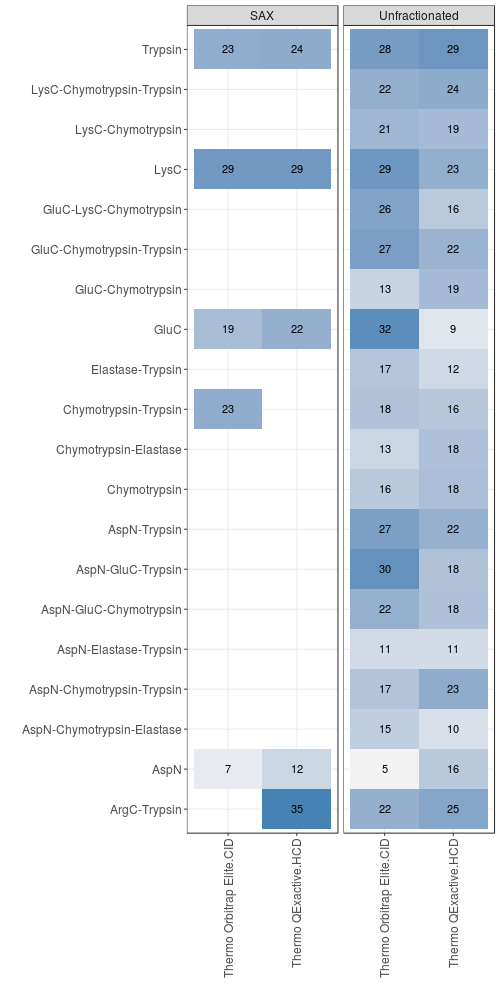

In [70]:
%%R -i tm_proteins_agg -i tm_proteins_agg2 -h 1000 -w 500
library(ggplot2)

tm_proteins_agg <- tm_proteins_agg[tm_proteins_agg$fragmentation %in% c("CID", "HCD"),]
tm_proteins_agg2 <- tm_proteins_agg2[tm_proteins_agg2$fragmentation %in% c("CID", "HCD"),]

unfractionated_df <- tm_proteins_agg2[tm_proteins_agg2$fractionation=='Unfractionated',]
print(head(unfractionated_df))
top_digests_unfractioned = as.character(unfractionated_df[order(-unfractionated_df$protein),"digest"][0:20])
sax_digests = as.character(tm_proteins_agg[tm_proteins_agg$fractionation=='SAX',"digest"])
top_digests = unique(c(top_digests_unfractioned, sax_digests))


tm_proteins_agg <- tm_proteins_agg[tm_proteins_agg$digest %in% top_digests,]
tm_proteins_agg2 <- tm_proteins_agg2[tm_proteins_agg2$digest %in% top_digests,]


p  <- ggplot(tm_proteins_agg2, aes(y=digest, x=interaction(instrument, fragmentation))) +
geom_tile(aes(fill=protein)) +
facet_wrap(~fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=protein)) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)
ggsave("./results/Confetti_tm_protein_covered.png")


p  <- ggplot(tm_proteins_agg, aes(y=digest, x=interaction(instrument, fragmentation))) +
geom_tile(aes(fill=fraction_aa)) +
facet_wrap(~fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=round(100*fraction_aa,0))) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)
ggsave("./results/Confetti_aa_covered.png")


p  <- ggplot(tm_proteins_agg, aes(y=digest, x=interaction(instrument, fragmentation))) +
geom_tile(aes(fill=fraction_tms)) +
facet_wrap(~fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=round(100*fraction_tms,0))) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)
ggsave("./results/Confetti_tm_aa_covered.png")


[1] 2813   14
[1] 801  14
    protein               digest  fractionation            instrument
26   Q969S0    LysC-Chymotrypsin Unfractionated Thermo Orbitrap Elite
169  O75746 Chymotrypsin-Trypsin Unfractionated Thermo Orbitrap Elite
173  O75746                 LysC            SAX Thermo Orbitrap Elite
182  O75746         AspN-Trypsin Unfractionated      Thermo QExactive
200  O75746         ArgC-Trypsin            SAX      Thermo QExactive
202  O75746              Trypsin Unfractionated      Thermo QExactive
    fragmentation aa_covered tms_covered total_aa total_tms tms peptides
26            CID         10          10      331       227  11        1
169           CID         27          13      678       110   6        4
173           CID         78          38      678       110   6       12
182           HCD         71          13      678       110   6        9
200           HCD        271          35      678       110   6       39
202           HCD         77          19      

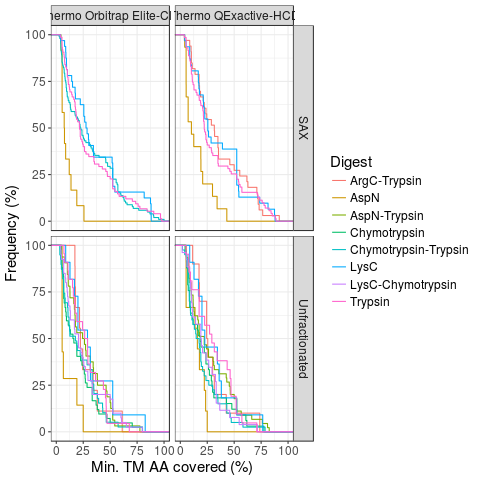

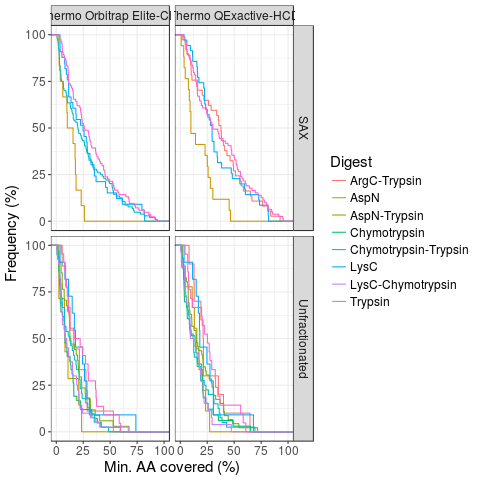

In [131]:
%%R -i tm_proteins_covered_df
tmp_df <- tm_proteins_covered_df
tmp_df$instFrag <- paste(tmp_df$instrument, tmp_df$fragmentation, sep="-")
print(dim(tmp_df))

top_digests_unfractioned = as.character(unfractionated_df[order(-unfractionated_df$protein),"digest"][0:4])
sax_digests = as.character(tm_proteins_agg[tm_proteins_agg$fractionation=='SAX',"digest"])
top_digests = unique(c(top_digests_unfractioned, sax_digests))

tmp_df <- tmp_df[tmp_df$digest %in% top_digests,]
tmp_df <- tmp_df[tmp_df$fragmentation %in% c("CID", "HCD"),]
tmp_df <- tmp_df[tmp_df$digest != "GluC",]
print(dim(tmp_df))
print(head(tmp_df))
print(top_digests)

p <- ggplot(tmp_df, aes(100*(tms_covered/total_tms), colour=digest)) +
stat_ecdf() +
facet_grid(fractionation~instFrag) +
theme_bw() +
scale_colour_discrete(name="Digest") +
xlab("Min. TM AA covered (%)") +
ylab("Frequency (%)") +
my_theme +
xlim(0,100) +
scale_y_continuous(trans = "reverse", labels=seq(100,0,-25))

print(p)
ggsave("./results/Confetti_tm_aa_covered_threshold.png", width=8, height=8)

p <- ggplot(tmp_df, aes(100*(aa_covered/total_aa), colour=digest)) +
stat_ecdf() +
facet_grid(fractionation~instFrag) +
theme_bw() +
scale_colour_discrete(name="Digest") +
xlab("Min. AA covered (%)") +
ylab("Frequency (%)") +
my_theme +
xlim(0,100) +
scale_y_continuous(trans = "reverse", labels=seq(100,0,-25))

print(p)
ggsave("./results/Confetti_aa_covered_threshold.png", width=8, height=8)

In [42]:
print(list(nls_ks_covered.keys())[0:10])
print(nls_ks_covered['Q14190'])

rows = []
header = ["protein", "digest", "fractionation", "instrument", "fragmentation", "covered", "total"]
for protein in nls_ks_covered:
    protein_values = nls_ks_covered[protein]
    protein_ks = nls_ks[protein]
    for combination in protein_values:
        digest, fractionation, instrument, fragmentation = combination.split(";")
        covered_ks = protein_values[combination]
        assert covered_ks.issubset(protein_ks)
        rows.append([protein, digest, fractionation, instrument, fragmentation,
                     len(covered_ks), len(protein_ks)])

print(protein)
print(digest, fractionation, instrument, fragmentation)
print(protein_ks)
print(nls_ks_covered[protein])
print(nls_ks_covered[protein][combination])
print(nls_ks[protein])
print(covered_ks)#
print(len(rows))

[1]
defaultdict(<class 'set'>, {})


AssertionError: 

In [ ]:
nls_proteins_df = pd.DataFrame.from_records(rows, columns=header)

nls_proteins_df['digest'] = nls_proteins_df['digest'].replace(
    "Cymotrypsin-Trypsin", "Chymotrypsin-Trypsin")         

nls_proteins_df['fraction'] = nls_proteins_df['covered']/nls_proteins_df['total']
print(nls_proteins_df.head())
print(nls_proteins_df.shape)

nls_proteins_covered_df = nls_proteins_df[nls_proteins_df['covered']>0]
print(nls_proteins_covered_df.shape)

nls_proteins_covered_agg = pd.DataFrame(nls_proteins_covered_df.groupby(
    ["digest", "fractionation", "instrument", "fragmentation"])['covered'].agg(len)).reset_index()

print(nls_proteins_covered_agg.shape)
print(nls_proteins_covered_agg.head())

print(nls_proteins_covered_agg.sort_values("covered", ascending=False).head())


nls_proteins_df_agg = pd.DataFrame(nls_proteins_df.groupby(
    ["digest", "fractionation", "instrument", "fragmentation"])['fraction'].agg(np.mean)).reset_index()

print(nls_proteins_df_agg.head())

nls_proteins_covered_df_agg = pd.DataFrame(nls_proteins_covered_df.groupby(
    ["digest", "fractionation", "instrument", "fragmentation"])['fraction'].agg(np.mean)).reset_index()

print(nls_proteins_covered_df_agg.head())


In [ ]:
%%R -i nls_proteins_covered_agg
library(ggplot2)

nls_proteins_covered_agg <- nls_proteins_covered_agg[
    nls_proteins_covered_agg$fragmentation %in% c("HCD", "CID"),]

m_txt = element_text(size=15)
my_theme = theme(
text=m_txt)


top_digests = as.character(nls_proteins_covered_agg[order(-nls_proteins_covered_agg$covered),"digest"][0:30])
sax_digests = as.character(nls_proteins_covered_agg[nls_proteins_covered_agg$fractionation=='SAX',"digest"])
top_digests = unique(c(top_digests, sax_digests))

nls_proteins_covered_agg_top <- nls_proteins_covered_agg[nls_proteins_covered_agg$digest %in% top_digests,]

p  <- ggplot(nls_proteins_covered_agg_top, aes(y=digest, x=interaction(instrument, fragmentation))) +
geom_tile(aes(fill=covered)) +
facet_wrap(~fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=covered)) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_protein_covered.png")

In [ ]:
%%R -i nls_proteins_covered_df_agg

nls_proteins_covered_df_agg <- nls_proteins_covered_df_agg[
    nls_proteins_covered_df_agg$fragmentation %in% c("HCD", "CID"),]

library(ggplot2)

m_txt = element_text(size=15)
my_theme = theme(
text=m_txt)


nls_proteins_covered_df_agg_top <- nls_proteins_covered_df_agg[
    nls_proteins_covered_df_agg$digest %in% top_digests,]

nls_proteins_covered_df_agg_top <- nls_proteins_covered_df_agg_top[
    !nls_proteins_covered_df_agg_top$digest=='GluC',]

p  <- ggplot(nls_proteins_covered_df_agg_top,
             aes(y=digest, x=interaction(instrument, fragmentation))) +
geom_tile(aes(fill=fraction)) +
facet_wrap(~fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=round(fraction,2))) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_protein_fraction.png")

In [ ]:
nls_df = pd.read_table("results/Confetti_intersect_nls.csv", sep="\t")
nls_df['Digest'] = [x.replace("Cymotrypsin", "Chymotrypsin") for x in nls_df['Digest']]
print(nls_df.shape)
print(nls_df.head())
nls_df = nls_df[nls_df['matched']==1]
print(nls_df.shape)

print(nls_df.head())
print(nls_df.sort_values("nls_Ks", ascending=False).head())

In [ ]:
%%R -i nls_df
library(ggplot2)

final_df = nls_df
print(head(final_df))
#final_df = nls_df[nls_df$Fractionation=='SAX',]

In [ ]:
%%R

library(ggplot2)
library(dplyr)
#grouped <- group_by(melted, sex, treatment)
#summarise(grouped, mean=mean(value), sd=sd(value))
dd <- group_by(final_df, Digest, Fractionation, Instrument, Fragmentation)
summed_df <- data.frame(summarise(dd, sum_nls_Ks = sum(nls_Ks), ave_nls_Ks = mean(nls_Ks)))
print(head(summed_df))

In [ ]:
%%R -h 500 -w 400
m_txt = element_text(size=15)
my_theme = theme(
text=m_txt)


print(dim(final_df))

print(sort(table(nls_df$Digest),decreasing=TRUE)[1:10])
digests = names(sort(table(nls_df$Digest),decreasing=TRUE)[1:10])

print(length(digests))

final_summed_df = summed_df[summed_df$Digest %in% digests,]
final_summed_df = final_summed_df[final_summed_df$Fragmentation %in% c("CID", "HCD"),]

p  = ggplot(final_summed_df, aes(y=Digest, x=interaction(Instrument, Fragmentation), fill=sum_nls_Ks)) +
geom_tile() +
facet_wrap(~Fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=sum_nls_Ks)) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_peptide_top.png")


p  = ggplot(final_summed_df, aes(y=Digest, x=interaction(Instrument, Fragmentation), fill=100*ave_nls_Ks)) +
geom_tile() +
facet_wrap(~Fractionation) +
geom_text(aes(label=100*round(ave_nls_Ks, 2))) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90))

print(p)

ggsave("./results/Confetti_peptide_fraction_top.png")


digests = unique(nls_df$Digest)
print(length(digests))
digests = digests[-grep('Trypsin', digests)]
digests = digests[-grep('LysC', digests)]
digests = digests[-grep("ArgC",digests)]

print(length(digests))

final_summed_df = summed_df[summed_df$Digest %in% digests,]
final_summed_df = final_summed_df[final_summed_df$Fragmentation %in% c("CID", "HCD"),]



p  = ggplot(final_summed_df, aes(y=Digest, x=interaction(Instrument, Fragmentation), fill=sum_nls_Ks)) +
geom_tile() +
facet_wrap(~Fractionation) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
geom_text(aes(label=sum_nls_Ks)) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_peptide_not_trp_lysc.png")

print(head(final_summed_df))

p  = ggplot(final_summed_df, aes(y=Digest, x=interaction(Instrument, Fragmentation), fill=100*ave_nls_Ks)) +
geom_tile() +
facet_wrap(~Fractionation) +
geom_text(aes(label=100*round(ave_nls_Ks, 2))) +
scale_fill_continuous(low="grey95", high="steelblue", guide=F) +
theme_bw() +
my_theme + xlab("") + ylab("") + 
theme(axis.text.x=element_text(angle=90))

print(p)

ggsave("./results/Confetti_peptide_fraction_not_trp_lysc.png")

In [ ]:
print(list(nls_ks_covered.keys())[0:10])
print(nls_ks_covered['Q9NPI1'])
print(list(nls_ks.keys())[0:10])

header = ["digest", "fractionation", "instrument", "fragmentation", "nls_lysines", "covered"]
rows = []
for protein in nls_ks:
    for experimental_set_up in nls_ks_covered[protein]:
            if len(nls_ks_covered[protein][experimental_set_up]) > 0:
                digest, fractionation, instrument, fragmentation = experimental_set_up.split(";")
                covered = len(nls_ks_covered[protein][experimental_set_up])
                rows.append([digest, fractionation, instrument, fragmentation,
                             len(nls_ks[protein]), covered])
nls_df = pd.DataFrame.from_records(rows, columns=header)
nls_df['instrument'] = list(map(lambda x: x.replace("Thermo ", ""), nls_df['instrument']))
print(nls_df.head())

In [ ]:
%%R  -i nls_df
print(head(nls_df))

In [ ]:
print(set(nls_df['fractionation']))
print(set(nls_df['instrument']))
print(set(nls_df['fragmentation']))

In [ ]:
%%R -i nls_df -w 500 -h 500
#nls_df <- nls_df[nls_df$fragmentation %in% c("CID", "HCD"),]

m_txt = element_text(size=15)
my_theme = theme(
text=m_txt)

dd <- group_by(nls_df, digest, fractionation, instrument, fragmentation)
summary_df <- data.frame(summarise(dd, count_nls_Ks = length(nls_lysines)))
dd <- group_by(summary_df, digest)
summary_df <- data.frame(summarise(dd, mean_count_nls_Ks = mean(count_nls_Ks)))
digests = summary_df[order(summary_df$mean_count_nls_Ks, decreasing=TRUE),'digest'][0:10]
print(digests)

dd <- group_by(nls_df, digest, fractionation, instrument, fragmentation)
nls_df <- data.frame(summarise(dd, sum_nls_Ks = sum(nls_lysines), count_nls_Ks = length(nls_lysines)))

nls_df = nls_df[nls_df$fragmentation %in% c("CID", "HCD"),]

p = ggplot(nls_df[nls_df$digest %in% digests,],
           aes(interaction(instrument, fragmentation), digest, fill=count_nls_Ks)) +
geom_tile() +
geom_text(aes(label=count_nls_Ks)) +
facet_wrap(~fractionation) +
scale_fill_continuous(guide=F, low="grey95", high="steelblue") +
xlab("") + ylab("") + 
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_counts_top.png")

digests = unique(nls_df$digest)
digests = digests[-grep('Trypsin', digests)]
digests = digests[-grep('LysC', digests)]


p = ggplot(nls_df[nls_df$digest %in% digests,],
           aes(interaction(instrument, fragmentation), digest, fill=count_nls_Ks)) +
geom_tile() +
geom_text(aes(label=count_nls_Ks)) +
facet_wrap(~fractionation) +
scale_fill_continuous(guide=F, low="grey95", high="steelblue") +
xlab("") + ylab("") + 
theme_bw() +
my_theme +
theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

print(p)

ggsave("./results/Confetti_counts_not_typ_lysc.png")

In [ ]:
%%R
fit <- lm(nls_df_frag_cast$SAX ~ nls_df_frag_cast$Unfractionated -1 )
print(summary(fit)$r.squared)
print(summary(fit))
print(format(coef(fit)[1], digits=2))


In [ ]:
%%R


In [ ]:
%%R
library(reshape2)
print(head(nls_df))
nls_df_frag_cast <- dcast(nls_df, digest+instrument+fragmentation~fractionation,
                          value.var="count_nls_Ks", fun.aggregate=mean)

fit <- lm(nls_df_frag_cast$SAX ~ nls_df_frag_cast$Unfractionated -1 )

r_squared <- summary(fit)$r.squared
slope <- format(coef(fit)[1], digits=2)

m_txt = element_text(size=20)
my_theme = theme(
text=m_txt,
aspect.ratio=1)

p <- ggplot(nls_df_frag_cast, aes(Unfractionated, SAX)) +
geom_point(size=4) +
geom_smooth(method='lm') +
theme_bw() +
coord_cartesian(xlim = c(0, 45), ylim=c(0,90)) +
my_theme +
ggtitle(paste("Slope = ", format(coef(fit)[1], digits=2),
              "\nR2 =", format(summary(fit)$adj.r.squared, digits=4)))

print(p)

ggsave("./results/Confetti_corr_fractionation.png")

In [ ]:
ggsave("./results/Confetti_counts_not_typ_lysc.png")